In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [3]:
!pip install dill

In [4]:
import pandas as pd
import numpy as np
import dill
from sklearn.utils import shuffle

# Read train data

In [5]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed_under')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed_under')['target_event']

# Load test pipline

In [6]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as f:
    test_pipeline = dill.load(f)

# Read test data and transform

In [7]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

# Binary evaluation class

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

In [9]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

---
# ***Support Vector Machines Classifier Model***
---

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialize SVM Classifier

In [18]:
svm = SVC(random_state=42, tol = 0.1, C = 1, kernel = 'linear')

# Train the model


In [19]:
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=42, tol=0.1)

# Get the prediction on test data

In [20]:
svm_pred = svm.predict(X_test)

# Create evaluation object

In [21]:
svm_eval = BinaryClassificationEvaluation(y_test, svm_pred)

# Evaluate prediction in from different corner

In [22]:
print(svm_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     15296
           1       0.72      0.75      0.74      7226

    accuracy                           0.83     22522
   macro avg       0.80      0.81      0.80     22522
weighted avg       0.83      0.83      0.83     22522



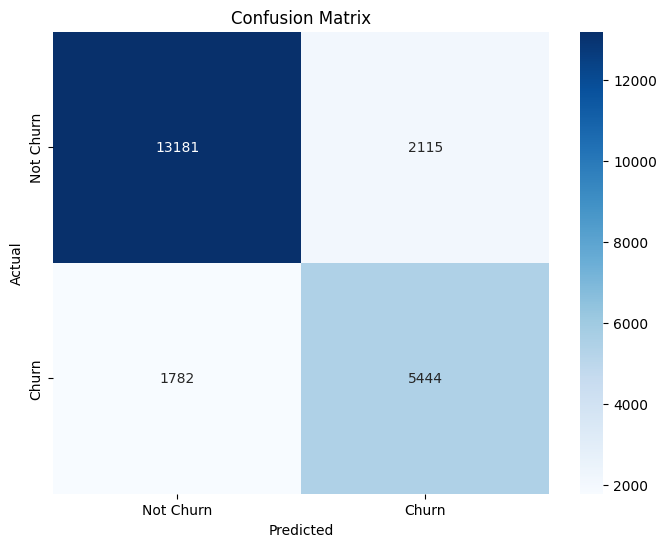

In [23]:
svm_eval.visualize_confusion_matrix()

In [29]:
precision, recall, f1 = svm_eval.precision_recall_f1()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.72
Recall: 0.75
F1 Score: 0.74


In [31]:
accuracy = svm_eval.accuracy()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


# Save the model

In [35]:
with open('/content/drive/MyDrive/Churn Prediction/svm_model_churn.pkl', 'wb') as f:
    dill.dump(svm, f)